In [1]:
from importlib import reload
import dnd
reload(dnd)

import numpy as np

1360.992431640625 1589.781982421875


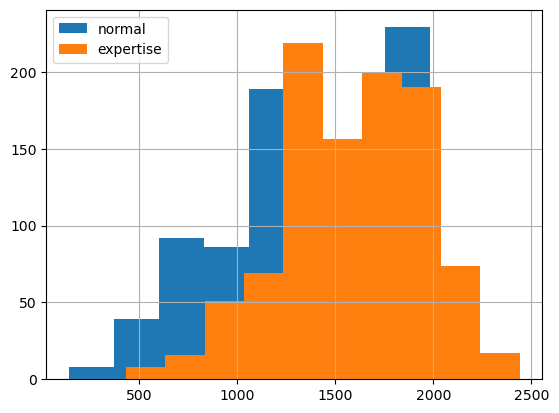

In [3]:
proficiency = 6
charisma = 5

intimidation = proficiency  + charisma
deception = proficiency  + charisma
insight = proficiency  

bonus = [intimidation, deception, insight]

intimidation = 2*proficiency  + charisma
deception = proficiency  + charisma
insight = proficiency  

expertise_bonus = [intimidation, deception, insight]

print(dnd.simulate_gambling_downtime(4, 0.25, *bonus).mean(), dnd.simulate_gambling_downtime(4, 0.25, *expertise_bonus).mean())

ax = dnd.simulate_gambling_downtime(4, 0.25, *bonus).hist(label='normal')
ax = dnd.simulate_gambling_downtime(4, 0.25, *expertise_bonus).hist(label='expertise')
ax.legend()

In [3]:
# skele
config = dict(
    name = f'skele',
    paladin_lvl = 8,
    warlock_lvl = 12,
    attack_modifier = 4,
    damage_roll = dnd.dr(1,6),
    bonus_damage = 1+5,
    crit_added_damage = 0,
    crit_chance=0.05,
    num_attacks = 2,
    **dict(advantage=False, disadvantage=False)
)

{**config, **dnd.roll_damage(**config)}

{'name': 'skele',
 'paladin_lvl': 8,
 'warlock_lvl': 12,
 'attack_modifier': 4,
 'damage_roll': 3.452,
 'bonus_damage': 6,
 'crit_added_damage': 0,
 'crit_chance': 0.05,
 'num_attacks': 2,
 'advantage': False,
 'disadvantage': False,
 'probablity_hit': 0.30000000000000004,
 'defender_AC': 19,
 'crit_chance per round': 0.1,
 'hit damage': 9.452,
 'crit damage': 12.904,
 'expected damage per hit': 3.0082000000000004,
 'expected damage per round': 6.016400000000001}

In [5]:
# griffin
config = dict(
    name = f'griffin',
    paladin_lvl = 8,
    warlock_lvl = 12,
    attack_modifier = 6,
    damage_roll = dnd.dr(1,8),
    bonus_damage = 4+5,
    crit_added_damage = 0,
    crit_chance=0.05,
    num_attacks = 2,
    **dict(advantage=False, disadvantage=False)
)

{**config, **dnd.roll_damage(**config)}

{'name': 'griffin',
 'paladin_lvl': 8,
 'warlock_lvl': 12,
 'attack_modifier': 6,
 'damage_roll': 4.513,
 'bonus_damage': 9,
 'crit_added_damage': 0,
 'crit_chance': 0.05,
 'num_attacks': 2,
 'advantage': False,
 'disadvantage': False,
 'probablity_hit': 0.4,
 'defender_AC': 19,
 'crit_chance per round': 0.1,
 'hit damage': 13.513,
 'crit damage': 18.026,
 'expected damage per hit': 5.630850000000001,
 'expected damage per round': 11.261700000000001}

In [8]:
# warlock 15
hex_curse = dnd.dr(1,6)
holy_weapon = 0 # dnd.dr(2,8)
divine_smite = 0 # dnd.dr(1,8)
charisma = 5
proficency = 5
dueling_style = 2
improved_pact_weapon = 1
is_hexblade_curse = False

spell_slots = [4]*6 + [2] * 3

crit_damages = [dnd.dr(2+ (lvl-1), 8) for lvl in spell_slots]



total_damage = 0
for crit_damage in crit_damages:
    config = dict(
        name = f'PAM + Duling Style\n+ Hexblade ',
        paladin_lvl = 8,
        warlock_lvl = 7,
        attack_modifier = charisma+proficency+improved_pact_weapon,
        damage_roll = dnd.dr(1,6) + hex_curse + divine_smite,
        bonus_damage = charisma + charisma + dueling_style + (charisma if is_hexblade_curse else 0) + improved_pact_weapon,
        crit_added_damage = crit_damage,
        crit_chance=0.10 + (0.05 if is_hexblade_curse else 0),
        num_attacks = 3,
        **dict(advantage=False, disadvantage=False)
    )
    total_damage += {**config, **dnd.roll_damage(**config)}['crit damage']

print(f'total damage: {total_damage}')

config['crit_added_damage'] = 0
dnd.roll_damage(**config)

total damage: 595.2560000000001


{'probablity_hit': 0.65,
 'defender_AC': 19,
 'crit_chance per round': 0.30000000000000004,
 'hit damage': 20.066499999999998,
 'crit damage': 27.133,
 'expected damage per hit': 13.749875,
 'expected damage per round': 41.249624999999995}

In [10]:
# pally 15
hex_curse = dnd.dr(1,6)
holy_weapon =  0 #dr(2,8)
divine_smite =  dnd.dr(1,8)
charisma = 5
proficency = 5
dueling_style = 0 #2
improved_pact_weapon = 0 #1
is_hexblade_curse = False

spell_slots = [4]*1 + [3] * 3 + [2] * 3 

crit_damages = [dnd.dr(2+ (lvl-1), 8) for lvl in spell_slots]



total_damage = 0
for crit_damage in crit_damages:
    config = dict(
        name = f'PAM + Duling Style\n+ Hexblade ',
        paladin_lvl = 8,
        warlock_lvl = 7,
        attack_modifier = charisma+proficency+improved_pact_weapon,
        damage_roll = dnd.dr(1,6) + hex_curse + divine_smite,
        bonus_damage = charisma + charisma + dueling_style + (charisma if is_hexblade_curse else 0) + improved_pact_weapon,
        crit_added_damage = crit_damage,
        crit_chance=0.10 + (0.05 if is_hexblade_curse else 0),
        num_attacks = 3,
        **dict(advantage=False, disadvantage=False)
    )
    total_damage += {**config, **dnd.roll_damage(**config)}['crit damage']

print(f'total damage: {total_damage}')

config['crit_added_damage'] = 0
dnd.roll_damage(**config)

total damage: 463.593


{'probablity_hit': 0.6,
 'defender_AC': 19,
 'crit_chance per round': 0.30000000000000004,
 'hit damage': 21.3975,
 'crit damage': 32.795,
 'expected damage per hit': 13.978250000000001,
 'expected damage per round': 41.93475}

In [12]:
# pally 15
hex_curse = dnd.dr(1,6)
holy_weapon =  0 #dnd.dr(2,8)
divine_smite =  dnd.dr(1,8)
charisma = 5
proficency = 5
dueling_style = 0 #2
improved_pact_weapon = 0 #1
is_hexblade_curse = False

spell_slots = [4]*1 + [3] * 3 + [2] * 3 

crit_damages = [dnd.dr(2+ (lvl-1), 8) for lvl in spell_slots]



total_damage = 0
for crit_damage in crit_damages:
    config = dict(
        name = f'PAM + Duling Style\n+ Hexblade ',
        paladin_lvl = 8,
        warlock_lvl = 7,
        attack_modifier = charisma+proficency+improved_pact_weapon,
        damage_roll = dnd.dr(1,6) + hex_curse + divine_smite,
        bonus_damage = charisma + charisma + dueling_style + (charisma if is_hexblade_curse else 0) + improved_pact_weapon,
        crit_added_damage = crit_damage,
        crit_chance=0.10 + (0.05 if is_hexblade_curse else 0),
        num_attacks = 3,
        **dict(advantage=False, disadvantage=False)
    )
    total_damage += {**config, **dnd.roll_damage(**config)}['crit damage']

print(f'total damage: {total_damage}')

config['crit_added_damage'] = 0
dnd.roll_damage(**config)

total damage: 466.61699999999996


{'probablity_hit': 0.6,
 'defender_AC': 19,
 'crit_chance per round': 0.30000000000000004,
 'hit damage': 21.563,
 'crit damage': 33.126,
 'expected damage per hit': 14.0941,
 'expected damage per round': 42.2823}

In [13]:
# warlock 20
hex_curse = dnd.dr(1,6)
holy_weapon = 0 # dr(2,8)
divine_smite = 0 # dr(1,8)
charisma = 5
proficency = 6
dueling_style = 2
improved_pact_weapon = 1
is_hexblade_curse = False


spell_slots = [4]*2*3 + [0]*9 #+ [2] * 3 + [0] * 3

crit_damages = [dnd.dr(2+ (lvl-1), 8) for lvl in spell_slots]

total_damage = 0
for crit_damage in crit_damages:
    config = dict(
        name = f'PAM + Duling Style\n+ Hexblade ',
        paladin_lvl = 8,
        warlock_lvl = 12,
        attack_modifier = charisma+proficency+improved_pact_weapon,
        damage_roll = dnd.dr(1,6) + hex_curse + divine_smite,
        bonus_damage = charisma + charisma + charisma + dueling_style + (charisma if is_hexblade_curse else 0) + improved_pact_weapon,
        crit_added_damage = crit_damage,
        crit_chance=0.10 + (0.05 if is_hexblade_curse else 0),
        num_attacks = 3,
        **dict(advantage=False, disadvantage=False)
    )
    total_damage += {**config, **dnd.roll_damage(**config)}['crit damage'] 

print(f'total damage: {total_damage}')

total damage: 831.5120000000001


In [14]:
# Pally 20
hex_curse = 0#dr(1,6)
holy_weapon =  dnd.dr(2,8)
divine_smite =  dnd.dr(1,8)
charisma = 5
proficency = 6
dueling_style = 0 #2
improved_pact_weapon = 0 #1
is_hexblade_curse = False

spell_slots = [4]*3 + [3]*2 + [2]*1 + [0]*9 # + [2] * 3 + [1]*4

crit_damages = [dnd.dr(2+ (lvl-1), 8) for lvl in spell_slots]


total_damage = 0
for crit_damage in crit_damages:
    config = dict(
        name = f'PAM + Duling Style\n+ Hexblade ',
        paladin_lvl = 8,
        warlock_lvl = 12,
        attack_modifier = charisma+proficency+improved_pact_weapon,
        damage_roll = dnd.dr(1,6) + hex_curse + divine_smite+ holy_weapon,
        bonus_damage = charisma + charisma  + dueling_style + (charisma if is_hexblade_curse else 0) + improved_pact_weapon,
        crit_added_damage = crit_damage,
        crit_chance=0.10 + (0.05 if is_hexblade_curse else 0),
        num_attacks = 3,
        **dict(advantage=False, disadvantage=False)
    )
    total_damage += {**config, **dnd.roll_damage(**config)}['crit damage'] 

print(f'total damage: {total_damage}')


total damage: 973.6539999999999


In [10]:
is_health_low = False

hunters_mark = dr(1,6)
hex_curse = 0.1
smite = dr(2,8)

In [11]:
# using polearm master + duling style
records = []

for bd in [2,0]:
    for param in [dict(advantage=False, disadvantage=False), 
                dict(advantage=True, disadvantage=False), 
                dict(advantage=False, disadvantage=True)]:
        
        param['bd'] = bd
                
        config = dict(
            name = f'PAM + Duling Style {bd}',
            paladin_lvl = 4,
            warlock_lvl = 0,
            attack_modifier = 4,
            damage_roll = dr(1,6),
            bonus_damage = 2+bd,
            crit_added_damage = smite,
            num_attacks = 2,
            **param
        )
        records.append({**config, **expected_damage(**config)})

        config = dict(
            name = f'PAM + Duling Style {bd}',
            paladin_lvl = 5,
            warlock_lvl = 0,
            attack_modifier = 5,
            damage_roll = dr(1,6),
            bonus_damage = 2+bd,
            crit_added_damage = smite,
            num_attacks = 3,
            **param
        )
        records.append({**config, **expected_damage(**config)})

        config = dict(
            name = f'PAM + Duling Style {bd}',
            paladin_lvl = 6,
            warlock_lvl = 0,
            attack_modifier = 5,
            damage_roll = dr(1,6),
            bonus_damage = 2+bd,
            crit_added_damage = smite,
            num_attacks = 3,
            **param
        )
        records.append({**config, **expected_damage(**config)})

        config = dict(
            name = f'PAM + Duling Style {bd}',
            paladin_lvl = 7,
            warlock_lvl = 0,
            attack_modifier = 5,
            damage_roll = dr(1,6),
            bonus_damage = 2+3+bd,
            crit_added_damage = smite,
            num_attacks = 3,
            **param
        )
        records.append({**config, **expected_damage(**config)})

        config = dict(
            name = f'PAM + Duling Style {bd}',
            paladin_lvl = 8,
            warlock_lvl = 0,
            attack_modifier = 5,
            damage_roll = dr(1,6),
            bonus_damage = 2+4+2,
            crit_added_damage = smite,
            num_attacks = 3,
            **param
        )
        records.append({**config, **expected_damage(**config)})

        config = dict(
            name = f'PAM + Duling Style {bd}',
            paladin_lvl = 6,
            warlock_lvl = 1,
            attack_modifier = 6,
            damage_roll = dr(1,6) + dr(1,6),
            bonus_damage = 3+bd,
            crit_added_damage = smite,
            num_attacks = 3,
            **param
        )
        records.append({**config, **expected_damage(**config)})

        config = dict(
            name = f'PAM + Duling Style\n+ Hexblade {bd}',
            paladin_lvl = 7,
            warlock_lvl = 1,
            attack_modifier = 6,
            damage_roll = dr(1,6) + dr(1,6),
            bonus_damage = 3+3+2,
            crit_added_damage = smite,
            num_attacks = 3,
            **param
        )
        records.append({**config, **expected_damage(**config)})
        
        config = dict(
            name = f'PAM + Duling Style\n+ Hexblade {bd}',
            paladin_lvl = 8,
            warlock_lvl = 1,
            attack_modifier = 7,
            damage_roll = dr(1,6) + dr(1,6),
            bonus_damage = 4+4+bd,
            crit_added_damage = smite,
            num_attacks = 3,
            **param
        )
        records.append({**config, **expected_damage(**config)})

        config = dict(
            name = f'PAM + Duling Style\n+ Hexblade {bd}',
            paladin_lvl = 7,
            warlock_lvl = 2,
            attack_modifier = 6,
            damage_roll = dr(1,6) + dr(1,6),
            bonus_damage = 3+3+bd,
            crit_added_damage = smite,
            num_attacks = 3,
            **param
        )
        records.append({**config, **expected_damage(**config)})


        config = dict(
            name = f'PAM + Duling Style\n+ Hexblade {bd}',
            paladin_lvl = 13,
            warlock_lvl = 2,
            attack_modifier = 11,
            damage_roll = dr(1,6) + dr(2,6) + dr(1,8),
            bonus_damage = 5+5+ bd,
            crit_added_damage = smite,
            crit_chance=0.1,
            num_attacks = 3,
            **param
        )
        records.append({**config, **expected_damage(**config)})

        config = dict(
            name = f'PAM + Duling Style\n+ Hexblade {bd}',
            paladin_lvl = 8,
            warlock_lvl = 7,
            attack_modifier = 11,
            damage_roll = dr(1,6) + dr(1,6),
            bonus_damage = 5+5 + bd,
            crit_added_damage = smite,
            crit_chance=0.1,
            num_attacks = 3,
            **param
        )
        records.append({**config, **expected_damage(**config)})

pam_records = records

In [12]:
# using teeth bite weapon + hunters mark (fey touched feat)
records = []
for param in [dict(advantage=False, disadvantage=False), 
              dict(advantage=True, disadvantage=False), 
              dict(advantage=False, disadvantage=True)]:
    
    config = dict(
        name = 'Teeth + hunters mark',
        paladin_lvl = 4,
        warlock_lvl = 0,
        attack_modifier = 6,
        damage_roll = dr(1,4) + dr(1,6),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 1,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'Teeth + hunters mark',
        paladin_lvl = 5,
        warlock_lvl = 0,
        attack_modifier = 7,
        damage_roll = dr(1,4) + dr(1,6),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'Teeth + hunters mark',
        paladin_lvl = 6,
        warlock_lvl = 0,
        attack_modifier = 7,
        damage_roll = dr(1,4) + dr(1,6),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'Teeth + hunters mark',
        paladin_lvl = 7,
        warlock_lvl = 0,
        attack_modifier = 7,
        damage_roll = dr(1,4) + dr(1,6),
        bonus_damage = 4+4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )
    records.append({**config, **expected_damage(**config)})
    
    config = dict(
        name = 'Teeth + hunters mark\n+ PAM',
        paladin_lvl = 8,
        warlock_lvl = 0,
        attack_modifier = 5,
        damage_roll = dr(1,4) + dr(1,6),
        bonus_damage = 2+2+2,
        crit_added_damage = smite,
        num_attacks = 3,
        **param
    )
    records.append({**config, **expected_damage(**config)})

teeth_fey_records = records

In [13]:
# teeth weapon + skill expert feat (non combat)
records = []

for param in [dict(advantage=False, disadvantage=False), 
              dict(advantage=True, disadvantage=False), 
              dict(advantage=False, disadvantage=True)]:
    config = dict(
        name = 'Teeth',
        paladin_lvl = 4,
        warlock_lvl = 0,
        attack_modifier = 6,
        damage_roll = dr(1,4),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 1,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'Teeth',
        paladin_lvl = 5,
        warlock_lvl = 0,
        attack_modifier = 7,
        damage_roll = dr(1,4),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )
    records.append({**config, **expected_damage(**config)})
    
    config = dict(
        name = 'Teeth',
        paladin_lvl = 6,
        warlock_lvl = 0,
        attack_modifier = 7,
        damage_roll = dr(1,4),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )

    records.append({**config, **expected_damage(**config)})

    

teeth_records = records


In [14]:

df = pd.DataFrame.from_records(teeth_records+pam_records+teeth_fey_records)
df['level'] = df.paladin_lvl + df.warlock_lvl

display_cols = ['name', 'level', 'advantage', 'disadvantage', 'paladin_lvl', 'warlock_lvl', 'expected damage per round']
sort_cols = ['level', 'paladin_lvl', 'warlock_lvl', 'name', 'advantage', 'disadvantage']

In [15]:
# set number or rows to display
pd.options.display.max_rows = 100
df.sort_values(sort_cols)[display_cols]

,name,level,advantage,disadvantage,paladin_lvl,warlock_lvl,expected damage per round
42,PAM + Duling Style 0,4,False,False,4,0,6.00000
64,PAM + Duling Style 0,4,False,True,4,0,1.45500
53,PAM + Duling Style 0,4,True,False,4,0,10.54500
9,PAM + Duling Style 2,4,False,False,4,0,7.40000
31,PAM + Duling Style 2,4,False,True,4,0,1.94500
20,PAM + Duling Style 2,4,True,False,4,0,12.85500
0,Teeth,4,False,False,4,0,3.95000
6,Teeth,4,False,True,4,0,1.36750
3,Teeth,4,True,False,4,0,6.53250
75,Teeth + hunters mark,4,False,False,4,0,5.70000


In [16]:
df.query('disadvantage==False & advantage==True').sort_values(sort_cols)[display_cols]

,name,level,advantage,disadvantage,paladin_lvl,warlock_lvl,expected damage per round
53,PAM + Duling Style 0,4,True,False,4,0,10.54500
20,PAM + Duling Style 2,4,True,False,4,0,12.85500
3,Teeth,4,True,False,4,0,6.53250
80,Teeth + hunters mark,4,True,False,4,0,9.31500
54,PAM + Duling Style 0,5,True,False,5,0,16.84875
21,PAM + Duling Style 2,5,True,False,5,0,20.68875
4,Teeth,5,True,False,5,0,13.74750
81,Teeth + hunters mark,5,True,False,5,0,19.68000
55,PAM + Duling Style 0,6,True,False,6,0,16.84875
22,PAM + Duling Style 2,6,True,False,6,0,20.68875


In [17]:
df.query('disadvantage==False & advantage==False & bd==0').sort_values(sort_cols)[display_cols]

,name,level,advantage,disadvantage,paladin_lvl,warlock_lvl,expected damage per round
42,PAM + Duling Style 0,4,False,False,4,0,6.000
43,PAM + Duling Style 0,5,False,False,5,0,9.825
44,PAM + Duling Style 0,6,False,False,6,0,9.825
47,PAM + Duling Style 0,7,False,False,6,1,15.750
45,PAM + Duling Style 0,7,False,False,7,0,12.150
48,PAM + Duling Style\n+ Hexblade 0,8,False,False,7,1,21.750
46,PAM + Duling Style 0,8,False,False,8,0,15.300
50,PAM + Duling Style\n+ Hexblade 0,9,False,False,7,2,19.350
49,PAM + Duling Style\n+ Hexblade 0,9,False,False,8,1,24.000
52,PAM + Duling Style\n+ Hexblade 0,15,False,False,8,7,40.650


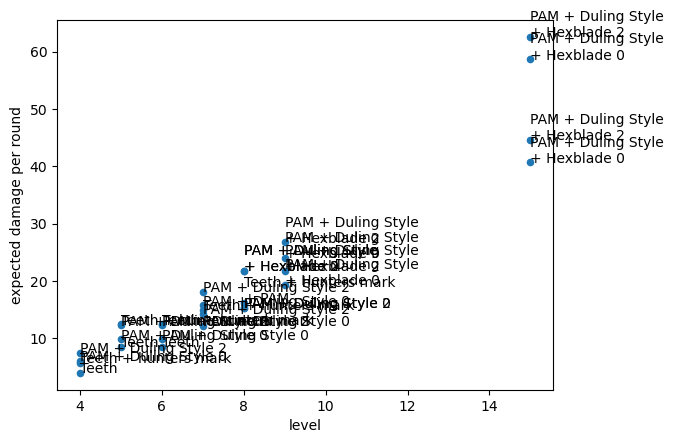

In [18]:
plot_df = df.query('advantage == False & disadvantage == False')
ax = plot_df.plot(x='level', y='expected damage per round', kind='scatter', )
for idx, row in plot_df.iterrows():
    ax.annotate(row['name'], (row['level'], row['expected damage per round']))

(1371.863037109375, 1617.574462890625)

In [27]:
dr(10,6)+40

75.0

In [103]:
(dr(1,6)+5)*3 + (dr(1,10)+5 + dr(1,6)+5)*3

57.0

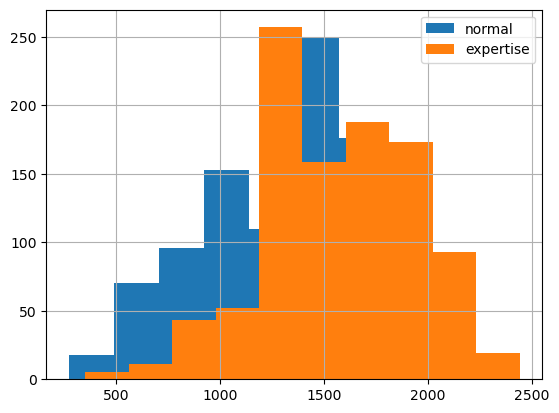

In [ ]:
purse = 1000
gamble = purse / 4
purse = purse - gamble

gambling_rolls(bonus)